In [ ]:
!pip3 -qq install torch==0.4.1
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

In [2]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [3]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)



In [4]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'X', 'ADV', 'ADJ', 'PRT', 'ADP', '.', 'PRON', 'DET', 'NOUN', 'NUM', 'VERB', 'CONJ'}


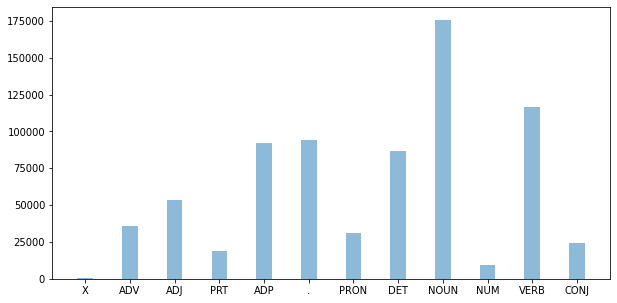

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

In [6]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [9]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [10]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 2))

X_batch.shape, y_batch.shape

((23, 2), (23, 2))

In [13]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1):
        super().__init__()
        self.hidden_size = lstm_hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, word_emb_dim)
        self.lstm = nn.LSTM(word_emb_dim, lstm_hidden_dim, lstm_layers_count)
        self.hidden2tag = nn.Linear(lstm_hidden_dim, tagset_size)
        

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space)
        return tag_scores


        

In [14]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [15]:
criterion = nn.CrossEntropyLoss(ignore_index=0)


In [16]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, scheduler, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    acc = 0
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)
                loss = criterion(logits.view(-1, 13), y_batch.view(-1))
                
                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
    
                _, indices = torch.max(logits, 2)
                cur_acc = torch.mean(torch.tensor(y_batch == indices, dtype=torch.float))
                acc += cur_acc
                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.5%}'.format(
                    name, loss.item(), cur_acc)
                )
            scheduler.step()
            acc = acc / batches_count
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.5%}'.format(
                name, epoch_loss / batches_count, acc)
            )

    return epoch_loss / batches_count, acc


def fit(model, criterion, optimizer, scheduler, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, scheduler, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, scheduler, None, name_prefix + '  Val:')

In [17]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
fit(model, criterion, optimizer, scheduler, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

  0%|          | 0/572 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[1 / 50] Train: Loss = 0.43529, Accuracy = 89.82725%: 100%|██████████| 572/572 [00:04<00:00, 118.68it/s]
[1 / 50]   Val: Loss = 0.17340, Accuracy = 95.41552%: 100%|██████████| 13/13 [00:00<00:00, 80.65it/s]
[2 / 50] Train: Loss = 0.16201, Accuracy = 95.08708%: 100%|██████████| 572/572 [00:04<00:00, 121.36it/s]
[2 / 50]   Val: Loss = 0.12998, Accuracy = 96.69463%: 100%|██████████| 13/13 [00:00<00:00, 83.65it/s]
[3 / 50] Train: Loss = 0.11960, Accuracy = 96.21589%: 100%|██████████| 572/572 [00:04<00:00, 

In [18]:

acc = 0
counter = 0
for i, (X_batch, y_batch) in enumerate(iterate_batches((X_test, y_test), 32)):
    X, y = LongTensor(X_batch), LongTensor(y_batch)
    logits = model(X)
    _, indices = torch.max(logits, 2)
    cur_acc = torch.mean(torch.tensor(y == indices, dtype=torch.float))
    acc += cur_acc
    counter = i
print("Final acc: ", acc.item() / counter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Final acc:  0.9572377727602419


In [19]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[================================================--] 96.0% 123.0/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [20]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))
torch.tensor(embeddings)

Know 38736 out of 45441 word embeddings


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0924,  0.0161, -0.5831,  ..., -0.0514,  0.2286, -1.7341],
        [-0.3224, -0.0658, -0.3195,  ...,  0.3234, -0.0442,  0.0700],
        ...,
        [-0.1556,  0.5396, -0.4734,  ..., -0.0702,  0.0244,  0.0887],
        [ 0.6666,  0.0853,  0.5238,  ..., -0.5173,  0.3076, -0.4327],
        [ 0.6431,  1.0674, -0.9012,  ..., -0.2400,  0.4884,  0.2977]],
       dtype=torch.float64)

In [21]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embeddings, tagset_size, lstm_hidden_dim=64, lstm_layers_count=1):
        super().__init__()
        self.hidden_size = lstm_hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        self.lstm = nn.LSTM(100, lstm_hidden_dim, 1, bidirectional=True)
        self.hidden2tag = nn.Linear(lstm_hidden_dim*2, tagset_size)
        

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds)
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space)
        return tag_scores

In [22]:
model = LSTMTaggerWithPretrainedEmbs(
    embeddings=torch.tensor(embeddings).float(),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
fit(model, criterion, optimizer, scheduler, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

  0%|          | 0/572 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[1 / 50] Train: Loss = 0.59277, Accuracy = 35.02402%: 100%|██████████| 572/572 [00:05<00:00, 113.55it/s]
[1 / 50]   Val: Loss = 0.26017, Accuracy = 24.93419%: 100%|██████████| 13/13 [00:00<00:00, 84.02it/s]
[2 / 50] Train: Loss = 0.19945, Accuracy = 34.97768%: 100%|██████████| 572/572 [00:05<00:00, 113.75it/s]
[2 / 50]   Val: Loss = 0.17916, Accuracy = 26.02004%: 100%|██████████| 13/13 [00:00<00:00, 83.61it/s]
[3 / 50] Train: Loss = 0.14334, Accuracy = 39.66945%: 100%|██████████| 572/572 [00:04<00:00, 

In [23]:

acc = 0
counter = 0
for i, (X_batch, y_batch) in enumerate(iterate_batches((X_test, y_test), 32)):
    X, y = LongTensor(X_batch), LongTensor(y_batch)
    logits = model(X)
    _, indices = torch.max(logits, 2)
    cur_acc = torch.mean(torch.tensor(y == indices, dtype=torch.float))
    acc += cur_acc
    counter = i
print("Final acc: ", acc.item() / counter)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Final acc:  0.3670244664953859
